In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pylab import rcParams

from mlforecast import MLForecast

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from src.data.loaders import CommodityLoader
from src.utils.split_series import split_series
from src.evaluation.evaluation import MetricEvaluator

In [74]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 
}
plt.rcParams.update(dark_style)

In [75]:
df_brl = CommodityLoader.load_all_commodities(currency='BRL', preprocessing=True, monthly_aggregation='mean', limit_date=None)

ദ്ദി・ᴗ・)✧ acucar_santos carregado com sucesso
ദ്ദി・ᴗ・)✧ acucar_sp carregado com sucesso
ദ്ദി・ᴗ・)✧ algodao carregado com sucesso
ദ്ദി・ᴗ・)✧ arroz carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_arabica carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_robusta carregado com sucesso
ദ്ദി・ᴗ・)✧ milho carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_paranagua carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_rs carregado com sucesso


In [76]:
df_brl.head()

,ds,y,unique_id
0,2020-01-01,73.428636,ACUCAR_SANTOS
1,2020-02-01,81.636111,ACUCAR_SANTOS
2,2020-03-01,79.906364,ACUCAR_SANTOS
3,2020-04-01,77.113500,ACUCAR_SANTOS
4,2020-05-01,84.638500,ACUCAR_SANTOS


In [77]:
df_brl.tail()

,ds,y,unique_id
2874,2025-01-01,1270.023636,TRIGO_RS
2875,2025-02-01,1324.566500,TRIGO_RS
2876,2025-03-01,1398.392632,TRIGO_RS
2877,2025-04-01,1469.926500,TRIGO_RS
2878,2025-05-01,1468.170000,TRIGO_RS


In [78]:
df_brl['unique_id'].unique()

array(['ACUCAR_SANTOS', 'ACUCAR_SP', 'ALGODAO', 'ARROZ', 'CAFE_ARABICA',
       'CAFE_ROBUSTA', 'MILHO', 'SOJA_PARANA', 'SOJA_PARANAGUA',
       'TRIGO_PARANA', 'TRIGO_RS'], dtype=object)

In [79]:
df_brl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2879 entries, 0 to 2878
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         2879 non-null   datetime64[ns]
 1   y          2879 non-null   float64       
 2   unique_id  2879 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 67.6+ KB


In [80]:
train, val, test = split_series(df_brl)

Splitted data into TRAIN with size 1605, VALIDATION with size 406 and TEST with size 868


In [81]:
model = make_pipeline(
    StandardScaler(), 
    SVR(
        C=10.0,
        gamma=0.5,
        epsilon=0.25
    )
)

fcst = MLForecast(
    models={'svr': model},
    lags=[1, 2],
    freq='MS'
)

# params found here https://www.nature.com/articles/s41598-024-74503-4/tables/7

In [82]:
# start tunning here if needed eventually

In [83]:
full_train = pd.concat([train, val])

In [84]:
fcst.fit(full_train)

MLForecast(models=[svr], freq=MS, lag_features=['lag1', 'lag2'], date_features=[], num_threads=1)

In [85]:
# Rollout
forecasts = []
for i in range(len(test)):
    f_next = fcst.predict(h=1)
    forecasts.append(f_next)

    # add real value
    obs = test.iloc[[i]][['unique_id', 'ds', 'y']]
    fcst.update(obs)

In [86]:
forecasts_df = pd.concat(forecasts, ignore_index=True)

In [87]:
evaluator = MetricEvaluator()

In [88]:
results = evaluator.evaluate_multiple(
    forecasts_df=forecasts_df,    
    actual_df=test,                
    model_columns=['svr'],         
    groupby_column='unique_id'     
)

print(results)

         unique_id Model  n_observations         MAE      MAPE            MSE  \
0    ACUCAR_SANTOS   svr              20    7.760497  0.053251     100.547483   
1        ACUCAR_SP   svr             100    5.902157  0.061499      46.563420   
2          ALGODAO   svr             205   11.805822  0.034093     346.357554   
3            ARROZ   svr             277    2.606547  0.044211      16.648875   
4     CAFE_ARABICA   svr             381  113.358398  0.089972  125316.880185   
5     CAFE_ROBUSTA   svr             468   48.725956  0.065585   40773.644194   
6            MILHO   svr             543    0.948559  0.017544       4.598987   
7      SOJA_PARANA   svr             644    2.452783  0.029525      11.763131   
8   SOJA_PARANAGUA   svr             714    6.482024  0.073338      44.821918   
9     TRIGO_PARANA   svr             791  198.301272  0.185886  114057.020957   
10        TRIGO_RS   svr             868  120.113533  0.110042   80366.401800   

          RMSE        R2  


In [89]:
summary = evaluator.get_summary_stats(results)
print("\n=== Estatísticas Resumo ===")
print(summary)


=== Estatísticas Resumo ===
           MAE                                       MAPE                  \
          mean      std     min       max  median    mean     std     min   
Model                                                                       
svr    47.1325  66.9544  0.9486  198.3013  7.7605  0.0695  0.0471  0.0175   

                              MSE                                            \
          max  median        mean         std    min          max    median   
Model                                                                         
svr    0.1859  0.0615  32825.9317  49981.7447  4.599  125316.8802  100.5475   

           RMSE                                          R2                  \
           mean      std     min       max   median    mean     std     min   
Model                                                                         
svr    111.7228  149.594  2.1445  354.0012  10.0273  0.1966  1.1346 -2.2476   

                       
    

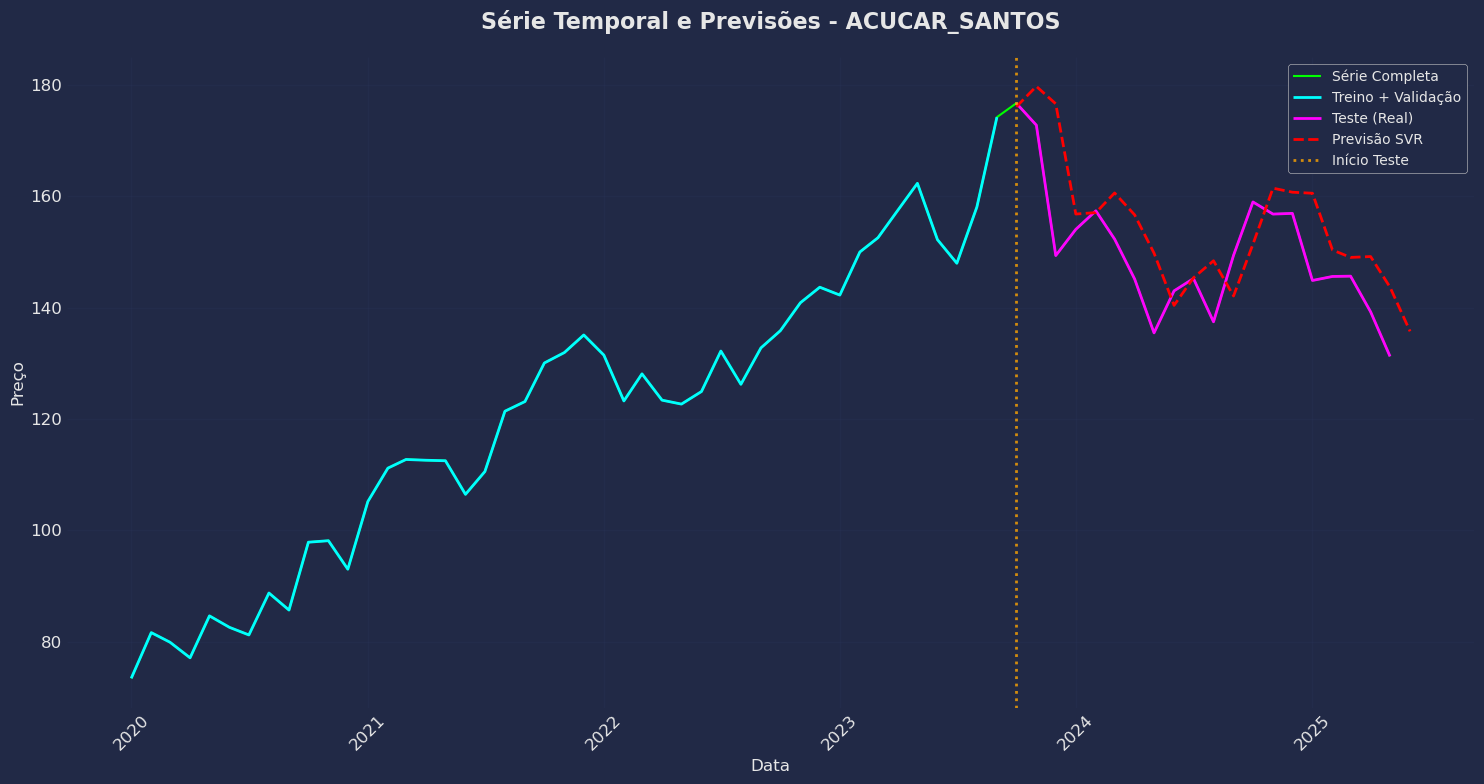

Gráfico exibido para: ACUCAR_SANTOS
--------------------------------------------------


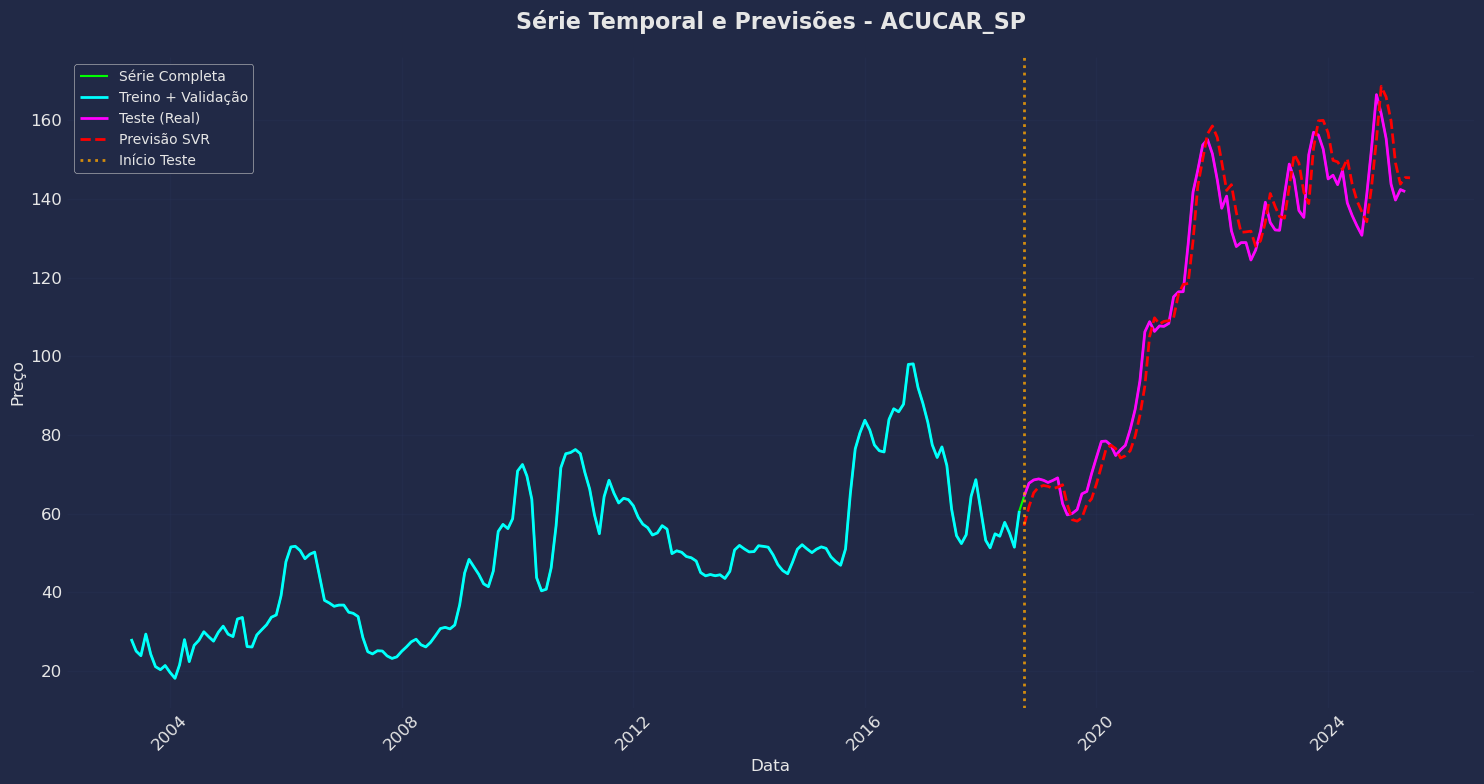

Gráfico exibido para: ACUCAR_SP
--------------------------------------------------


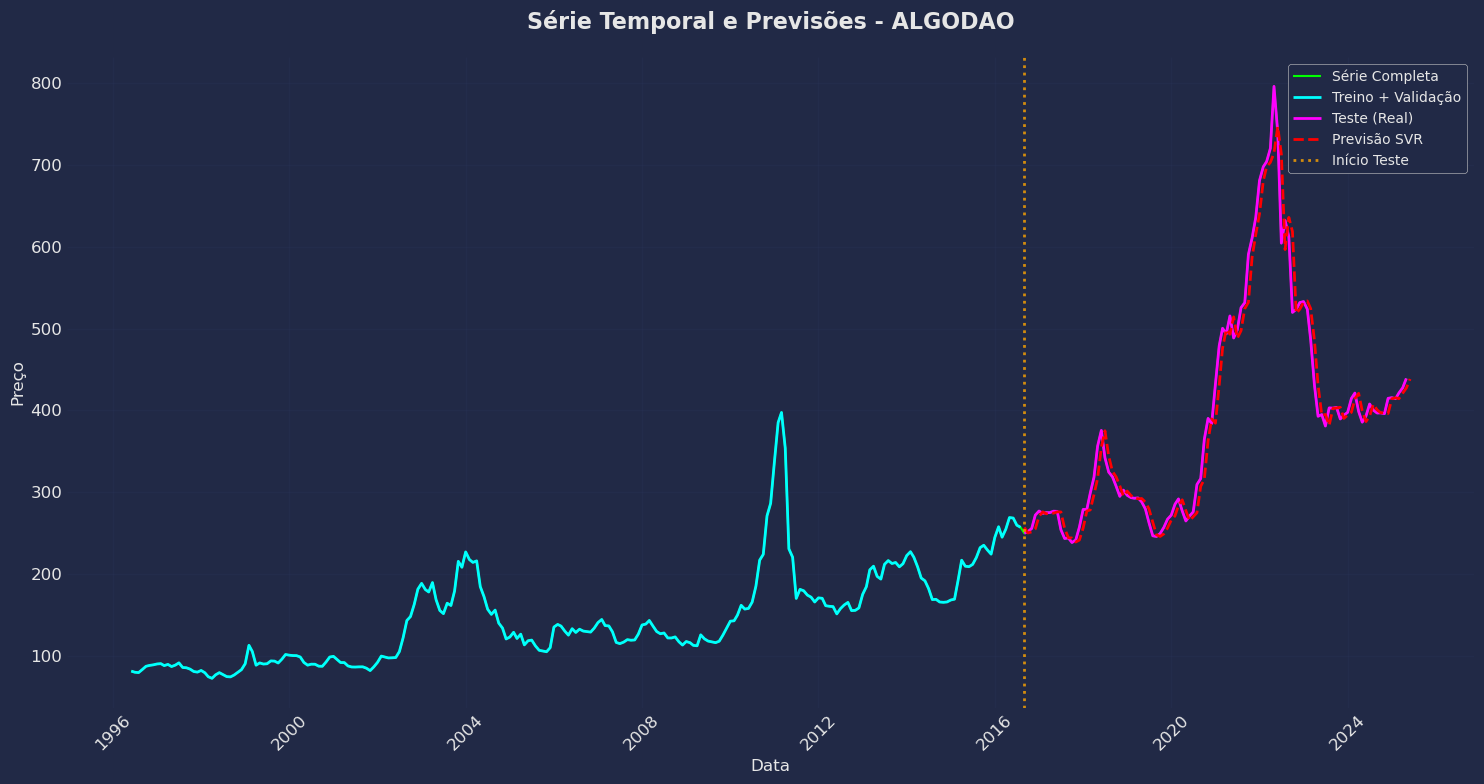

Gráfico exibido para: ALGODAO
--------------------------------------------------


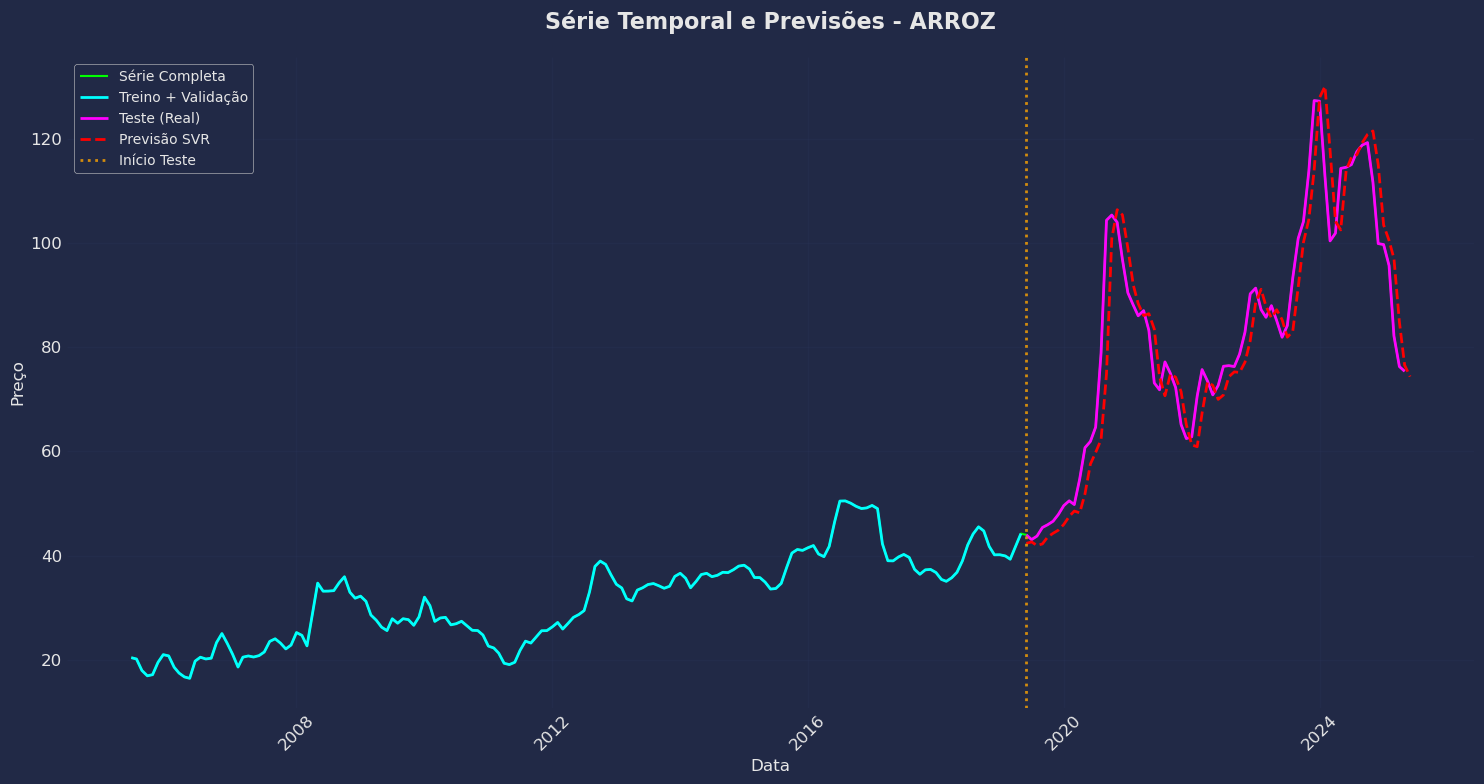

Gráfico exibido para: ARROZ
--------------------------------------------------


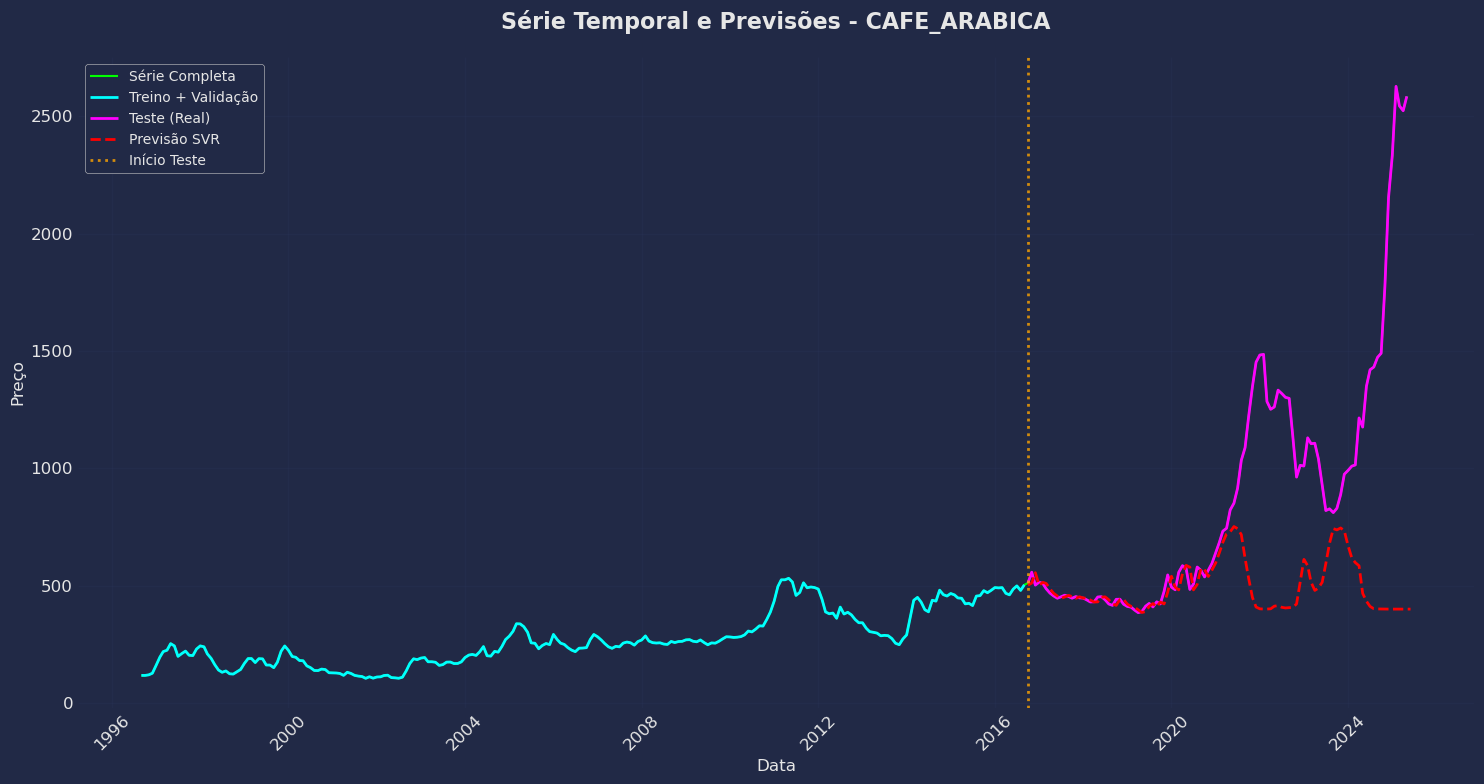

Gráfico exibido para: CAFE_ARABICA
--------------------------------------------------


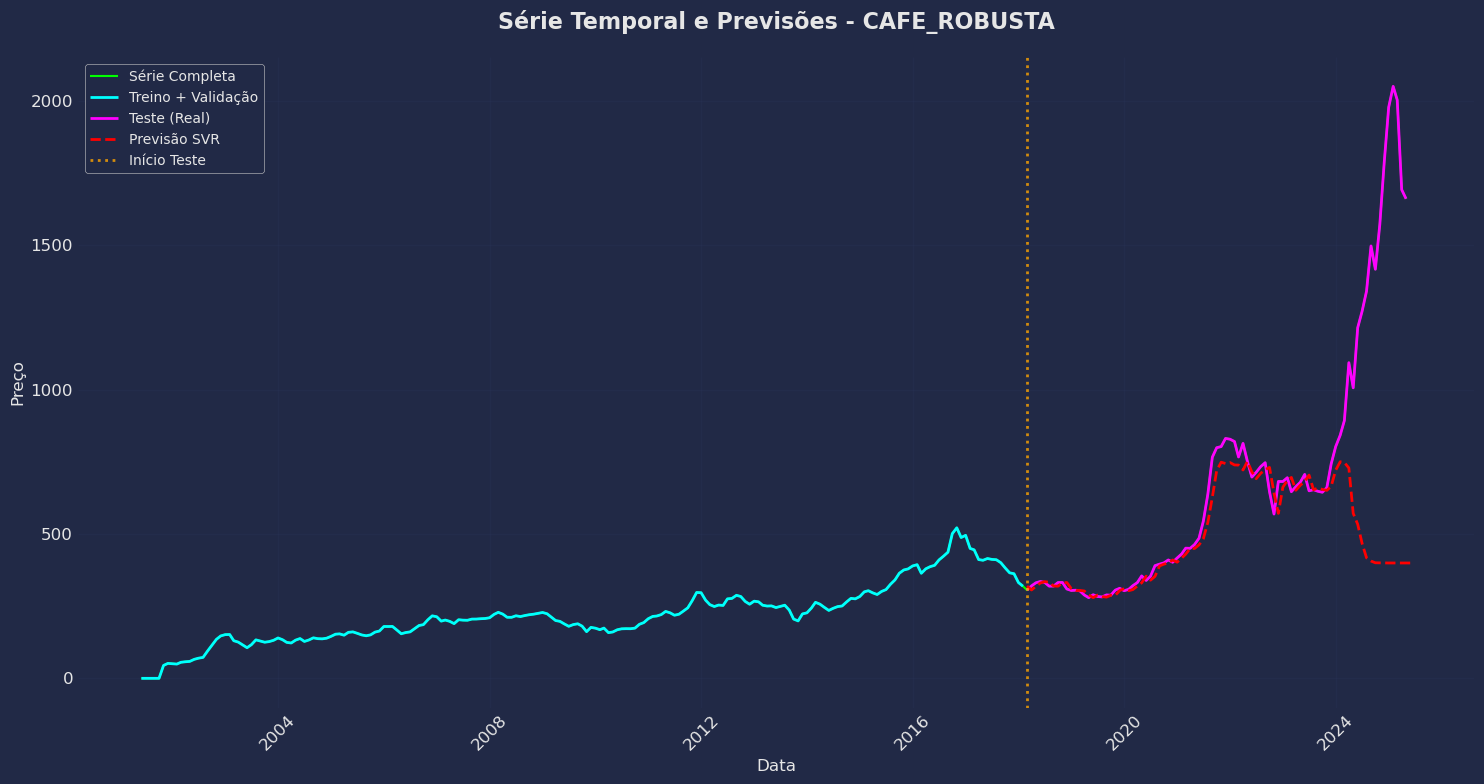

Gráfico exibido para: CAFE_ROBUSTA
--------------------------------------------------


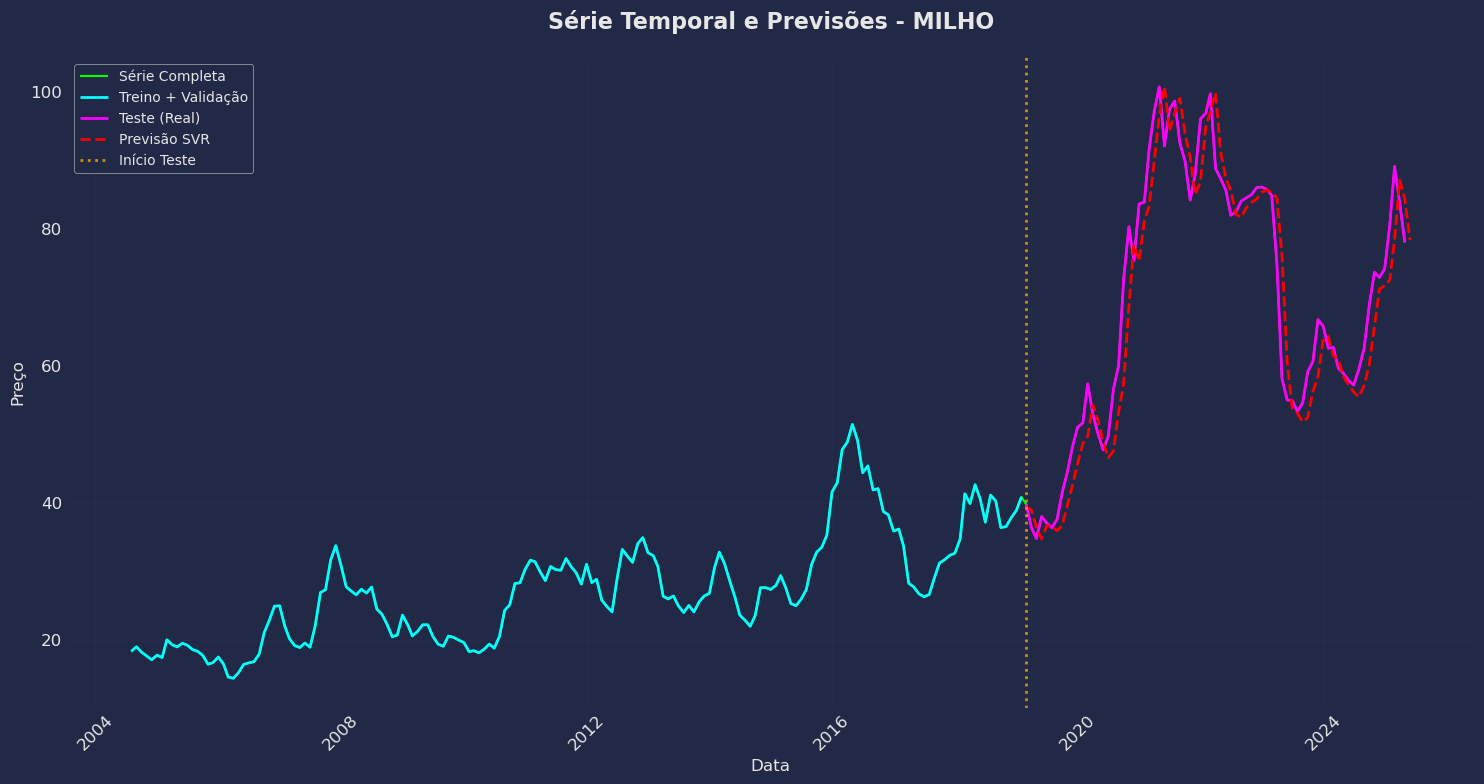

Gráfico exibido para: MILHO
--------------------------------------------------


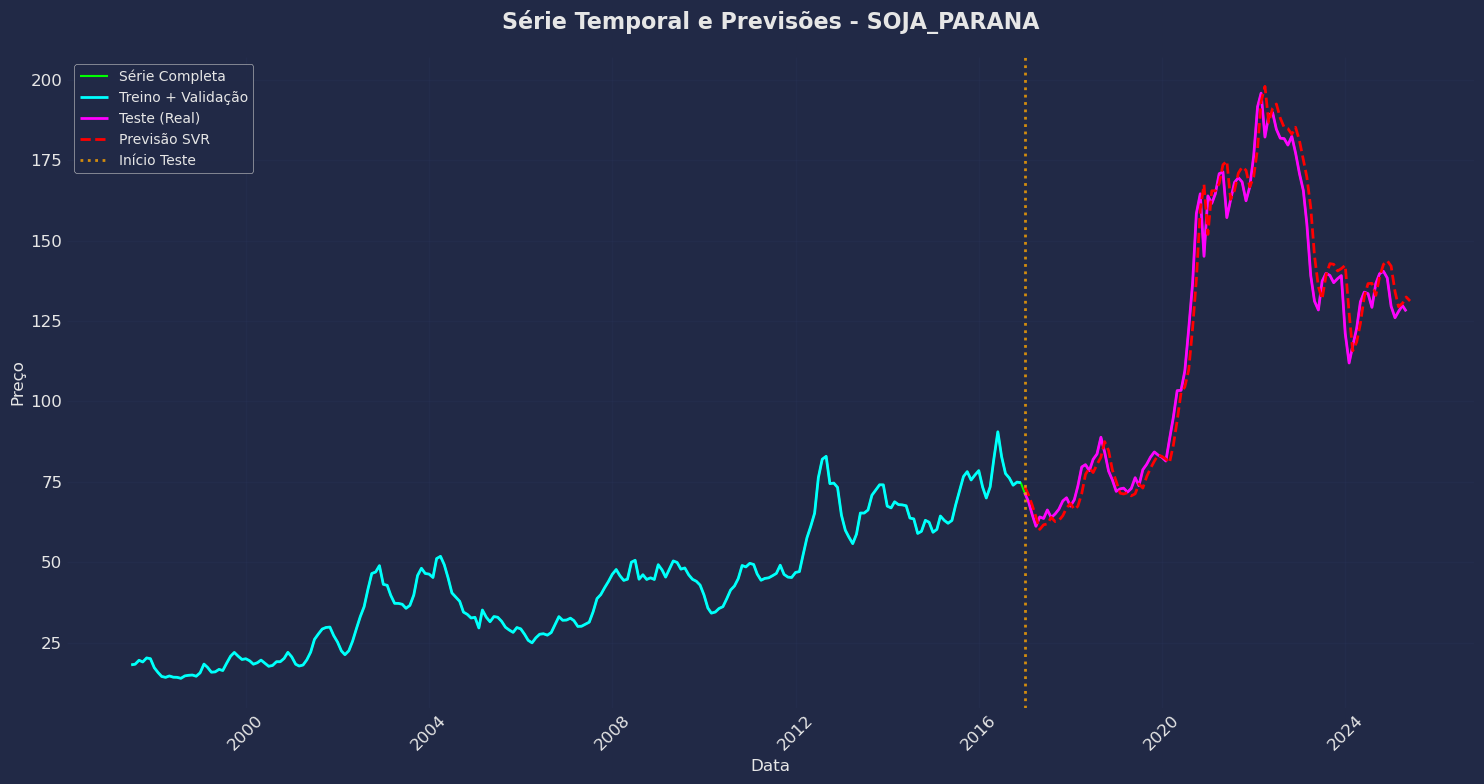

Gráfico exibido para: SOJA_PARANA
--------------------------------------------------


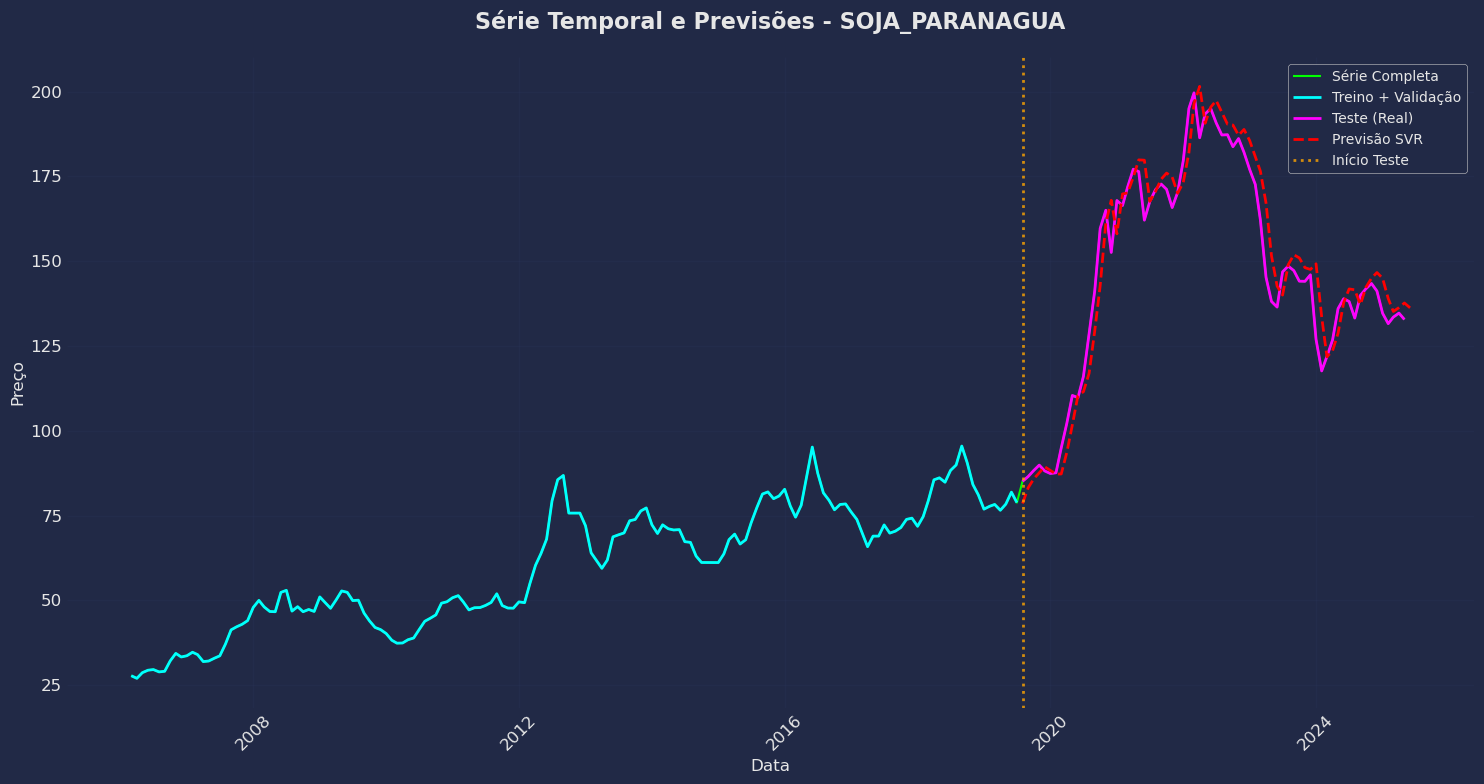

Gráfico exibido para: SOJA_PARANAGUA
--------------------------------------------------


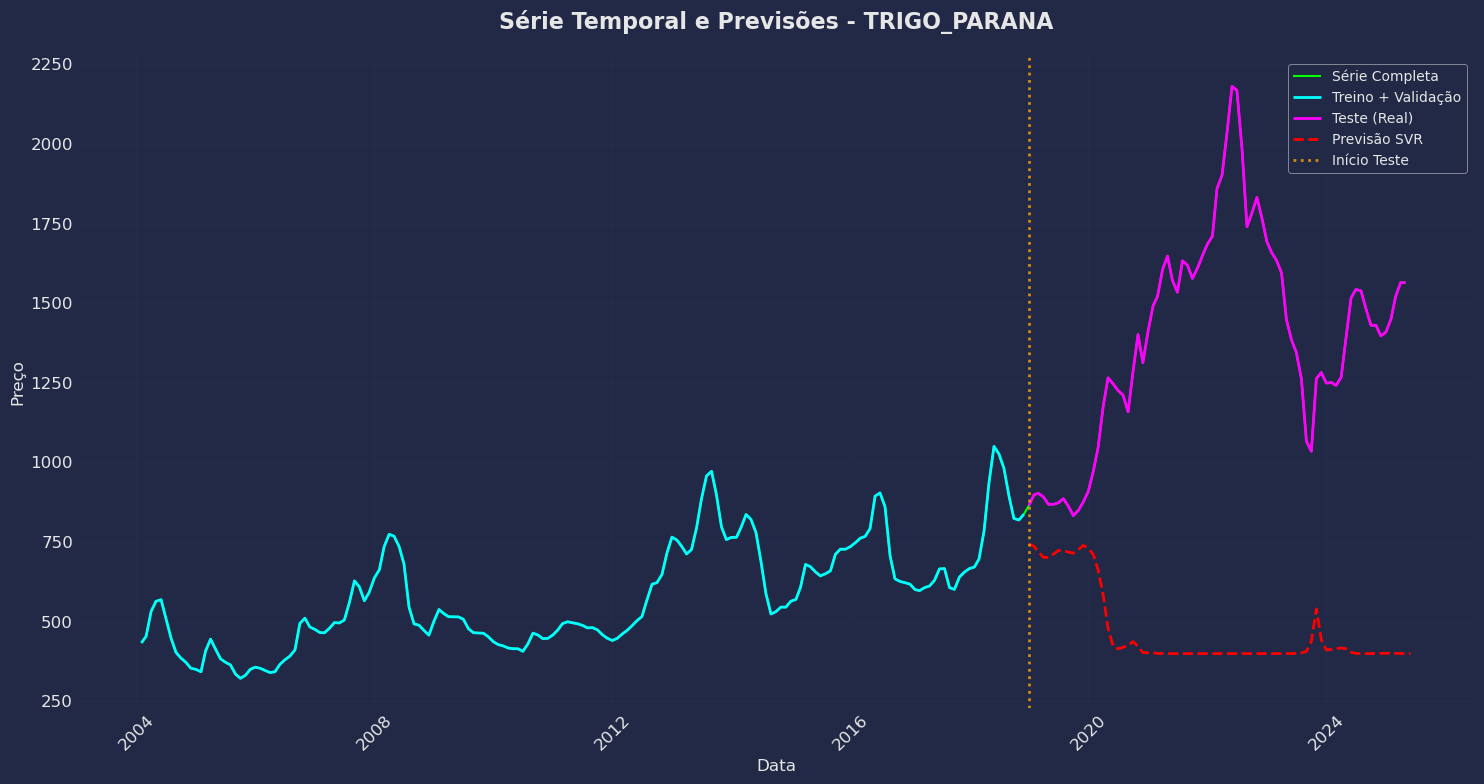

Gráfico exibido para: TRIGO_PARANA
--------------------------------------------------


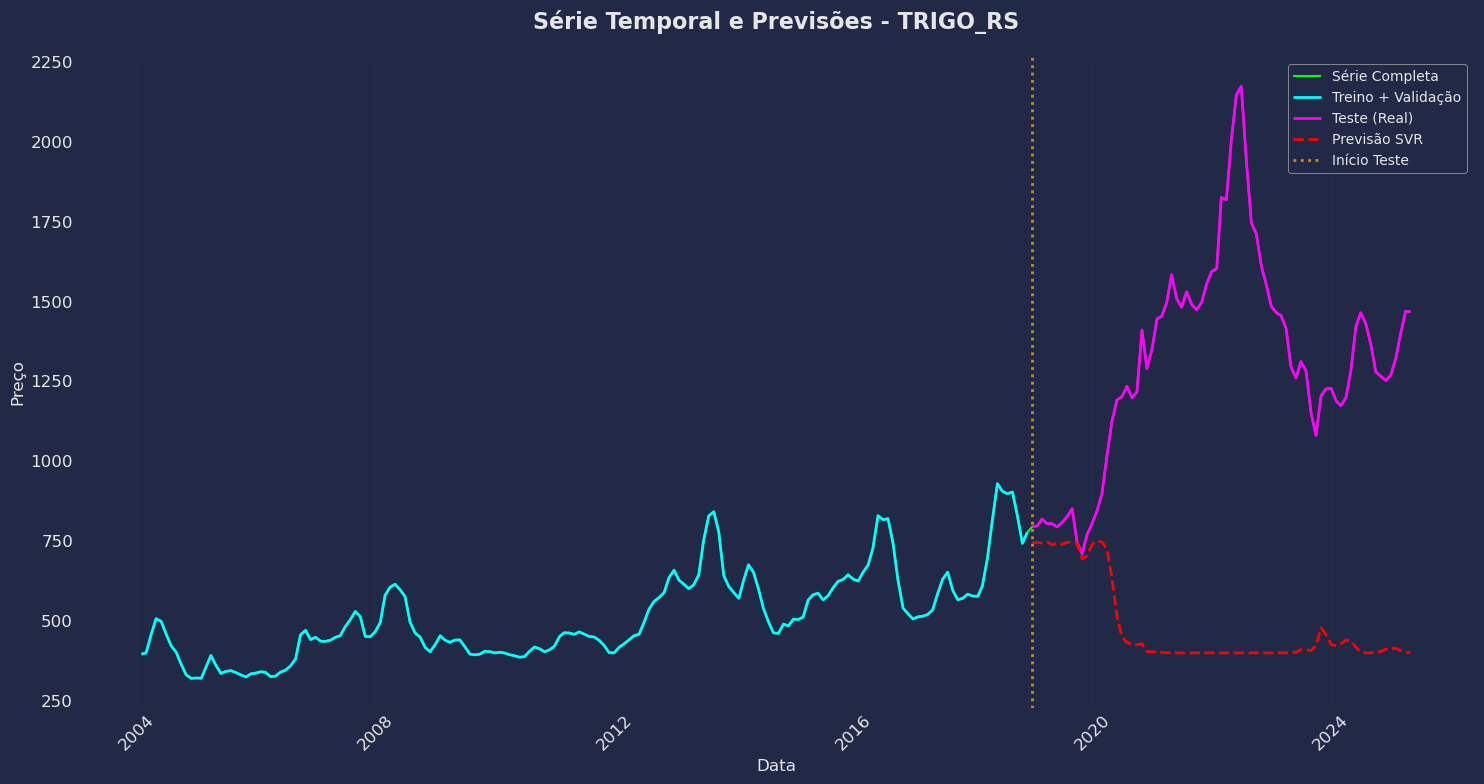

Gráfico exibido para: TRIGO_RS
--------------------------------------------------


In [97]:
def plot_series_and_forecasts(df_brl, full_train, test, forecasts_df):
    """
    Plota a série completa e as previsões para cada commodity individualmente
    """
    unique_ids = df_brl['unique_id'].unique()
    
    for uid in unique_ids:
        fig, ax = plt.subplots(1, 1, figsize=(15, 8))
        
        series_data = df_brl[df_brl['unique_id'] == uid].copy()
        train_data = full_train[full_train['unique_id'] == uid].copy()
        test_data = test[test['unique_id'] == uid].copy()
        forecast_data = forecasts_df[forecasts_df['unique_id'] == uid].copy()
        
        ax.plot(series_data['ds'], series_data['y'], 
                color='lime', linewidth=1.5, label='Série Completa')
        
        ax.plot(train_data['ds'], train_data['y'], 
                color='cyan', linewidth=2, label='Treino + Validação')
        
        ax.plot(test_data['ds'], test_data['y'], 
                color='fuchsia', linewidth=2, label='Teste (Real)')
        
        ax.plot(forecast_data['ds'], forecast_data['svr'], 
                color='red', linewidth=2, linestyle='--', label='Previsão SVR')
        
        if len(test_data) > 0:
            ax.axvline(x=test_data['ds'].iloc[0], color='orange', 
                      linestyle=':', alpha=0.8, linewidth=2, label='Início Teste')
        
        ax.set_title(f'Série Temporal e Previsões - {uid}', 
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Data', fontsize=12)
        ax.set_ylabel('Preço', fontsize=12)
        ax.legend(fontsize=10, loc='best')
        ax.grid(True, alpha=0.3)
        
        ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        
        plt.show()
        
        print(f"Gráfico exibido para: {uid}")
        print("-" * 50)

plot_series_and_forecasts(df_brl, full_train, test, forecasts_df)